<a href="https://colab.research.google.com/github/allexanderprastya/PROJECT-TA-JURNAL/blob/main/BERT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 32.4 MB/s 
     |████████████████████████████████| 120 kB 62.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 


In [4]:
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


warnings.filterwarnings('ignore')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = pd .read_csv('/content/review_15k_stopwords.csv')
df.head()

,content,sentiment
0,bodoh turun tersangkut langsung tolong tencent...,2
1,manga pubg memuat login kuota beli,0
2,bag pengembang perbaiki ngeluh bag lancar,2
3,berat putaran ma nyaman mainnya bagus,1
4,game bagus sayang jaringan turun game play sul...,2


In [16]:
class_names = ['negative', 'neutral', 'positive']

In [7]:
PRE_TRAINED_MODEL_NAME = 'indolem/indobert-base-uncased'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
sample_txt = 'kasih bintang bug terjun mendarat memegang tali terjun payung tanah menyesuaikan senjata ambil musuh mengambilnya duluan tolong perbaiki bug meresahkan playernya tolong pengembang pubg tolong perbaiki bugnya sekian terima kasih pubg'

In [11]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: kasih bintang bug terjun mendarat memegang tali terjun payung tanah menyesuaikan senjata ambil musuh mengambilnya duluan tolong perbaiki bug meresahkan playernya tolong pengembang pubg tolong perbaiki bugnya sekian terima kasih pubg
   Tokens: ['kasih', 'bintang', 'bug', 'terjun', 'mendarat', 'memegang', 'tali', 'terjun', 'payung', 'tanah', 'menyesuaikan', 'senjata', 'ambil', 'musuh', 'mengambilnya', 'duluan', 'tolong', 'perb', '##aiki', 'bug', 'meresahkan', 'player', '##nya', 'tolong', 'pengembang', 'pub', '##g', 'tolong', 'perb', '##aiki', 'bug', '##nya', 'sekian', 'terima', 'kasih', 'pub', '##g']
Token IDs: [3774, 3571, 9554, 7705, 9142, 5703, 6932, 7705, 12360, 2299, 11760, 3616, 8009, 5084, 26337, 27234, 9917, 2632, 4878, 9554, 20964, 18048, 1519, 9917, 11987, 19499, 938, 9917, 2632, 4878, 9554, 1519, 9101, 5218, 3774, 19499, 938]


In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 4)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 3)

In [20]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [21]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

In [22]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=80,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

80


tensor([    3,  3774,  3571,  9554,  7705,  9142,  5703,  6932,  7705, 12360,
         2299, 11760,  3616,  8009,  5084, 26337, 27234,  9917,  2632,  4878,
         9554, 20964, 18048,  1519,  9917, 11987, 19499,   938,  9917,  2632,
         4878,  9554,  1519,  9101,  5218,  3774, 19499,   938,     4,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [24]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

80


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'kasih',
 'bintang',
 'bug',
 'terjun',
 'mendarat',
 'memegang',
 'tali',
 'terjun',
 'payung',
 'tanah',
 'menyesuaikan',
 'senjata',
 'ambil',
 'musuh',
 'mengambilnya',
 'duluan',
 'tolong',
 'perb',
 '##aiki',
 'bug',
 'meresahkan',
 'player',
 '##nya',
 'tolong',
 'pengembang',
 'pub',
 '##g',
 'tolong',
 'perb',
 '##aiki',
 'bug',
 '##nya',
 'sekian',
 'terima',
 'kasih',
 'pub',
 '##g',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

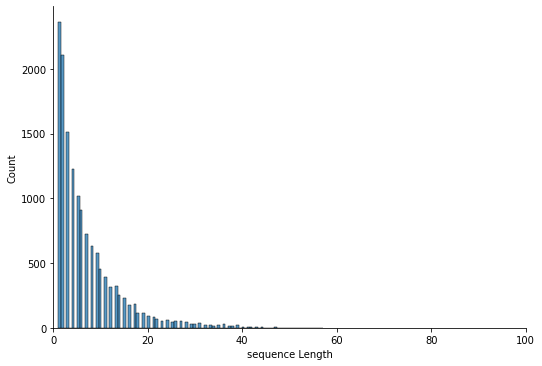

In [26]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.content]
ax = sns.displot(seq_len, height=5, aspect=1.5);
ax.set_xlabels('sequence Length');
ax.set(xlim=(0,100));

In [35]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
df1 = df[['content','sentiment']]
df1 = df1.rename(columns={'content':'review'})

In [40]:
# Load the data 
train = pd.read_csv('/content/train.csv')
val = pd.read_csv('/content/validation.csv')
test = pd.read_csv('/content/test.csv')

In [41]:
train.shape, val.shape, test.shape

((13041, 2), (724, 2), (725, 2))

In [42]:
## DataLoader
BATCH_SIZE = 32
MAX_LEN = 60

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [43]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [44]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 60])
torch.Size([32, 60])
torch.Size([32])


In [45]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
sample_txt = 'pengalaman bermain pubg mobile nyaman bermain peringkat mode platinum musuh bot kebanyakan pengalaman melawan pemain sulit terbiasa kontrol terbiasa jarak sulit jarak sarankan permudah pengaturan sensivitas rekomendasikan rendah grafis sulit musuh tim afk peringkat poinnya hilang'

In [47]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [48]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [49]:
bert_model.config.hidden_size

768

In [50]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    #Freeze bert layers
    # if freeze_bert:
    #   for p in self.bert.parameters():
    #       p.requires_grad = False
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [51]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
len(class_names)

3

In [53]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 60])
torch.Size([32, 60])


In [54]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2380, 0.5068, 0.2552],
        [0.3473, 0.4337, 0.2190],
        [0.4441, 0.2870, 0.2689],
        [0.3060, 0.3580, 0.3360],
        [0.3716, 0.3331, 0.2952],
        [0.4129, 0.3596, 0.2274],
        [0.3395, 0.4439, 0.2165],
        [0.2398, 0.3671, 0.3931],
        [0.3452, 0.2230, 0.4318],
        [0.3309, 0.4397, 0.2294],
        [0.4428, 0.2561, 0.3011],
        [0.4612, 0.3624, 0.1764],
        [0.5062, 0.2530, 0.2408],
        [0.2799, 0.2430, 0.4771],
        [0.5135, 0.3001, 0.1864],
        [0.3243, 0.4221, 0.2536],
        [0.3920, 0.3276, 0.2804],
        [0.3615, 0.3716, 0.2669],
        [0.3992, 0.3549, 0.2459],
        [0.3491, 0.2877, 0.3632],
        [0.5455, 0.2534, 0.2011],
        [0.1785, 0.5056, 0.3159],
        [0.3508, 0.3206, 0.3286],
        [0.2787, 0.4244, 0.2969],
        [0.4037, 0.3483, 0.2480],
        [0.2944, 0.3696, 0.3360],
        [0.3106, 0.3596, 0.3298],
        [0.4352, 0.2795, 0.2854],
        [0.3558, 0.3204, 0.3238],
        [0.413

In [55]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=.01, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [56]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  i=0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.1337080754193605 accuracy 0.36530940878766965
Val   loss 1.0690791347752446 accuracy 0.43922651933701656

Epoch 2/4
----------
Train loss 1.0758867342682445 accuracy 0.42412391687754003
Val   loss 1.049761362697767 accuracy 0.46270718232044195

Epoch 3/4
----------
Train loss 1.0512251398142647 accuracy 0.4515757994018863
Val   loss 1.0212425071260203 accuracy 0.4848066298342541

Epoch 4/4
----------
Train loss 1.0248782959054499 accuracy 0.46545510313626254
Val   loss 1.007621423057888 accuracy 0.4986187845303867

CPU times: user 6min 14s, sys: 2min 56s, total: 9min 11s
Wall time: 9min 18s


In [60]:
mod = SentimentClassifier(len(class_names))
mod.load_state_dict(torch.load('/content/best_model'))
mod = mod.to(device)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
test_acc, _ = eval_model(
  mod,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

test_acc.item()

0.5062068965517241

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [63]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  mod,
  test_data_loader
)

In [64]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.47      0.77      0.58       246
     neutral       0.47      0.12      0.19       246
    positive       0.58      0.63      0.60       233

    accuracy                           0.51       725
   macro avg       0.50      0.51      0.46       725
weighted avg       0.50      0.51      0.46       725



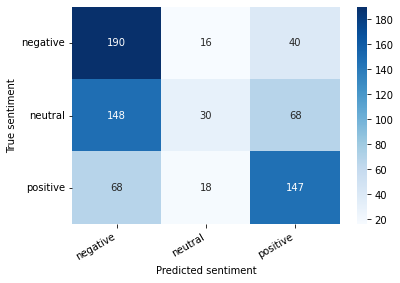

In [65]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [66]:
idx = 50

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [67]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

gacha anjing batas legend

True sentiment: negative


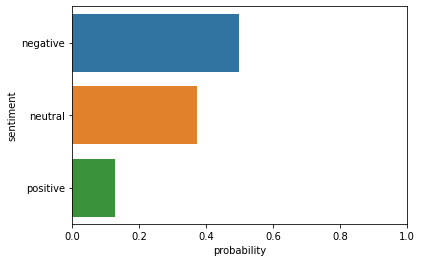

In [68]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [75]:
review_text = "malas main pemain cheat dari tier diamond tier ace cheat blokir"

In [76]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

In [77]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: malas main pemain cheat dari tier diamond tier ace cheat blokir
Sentiment  : negative
